# Gaussian bump potential 2 - noise modelling

This is the second in a series of notebooks which will run importance sampling for the Gaussian bump potential. Familiarity with stochastic inflation and covariance matrices is assumed, see for example https://arxiv.org/pdf/2303.17375

In this notebook we show how the different noise curves can be found using the background trajectory. We use the Bessel matching approach to find the homogeneous noise.

Throughout natural units with $c = 8\pi M_{\rm PL} = \hbar =1$ are used.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mystyle
plt.style.use(mystyle.paper_style)

from scipy.interpolate import CubicSpline
from scipy.integrate import odeint
from scipy.integrate import RK45
from scipy.optimize import root
from scipy.integrate import quad
from timeit import default_timer as timer

from mpmath import besselj as besselj_func
from mpmath import bessely as bessely_func
from mpmath import gamma as gamma_func

## The potential
This is the [Gaussian bump potential](https://arxiv.org/abs/1911.00057).

In [2]:
def potential(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction = (phi**2)/(m_squared + phi**2)
    return V_0*fraction*(1 + K*expo)

def potential_functional_form(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction = (phi**2)/(m_squared + phi**2)
    return fraction*(1 + K*expo)

def potential_dif(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction1 = (phi**2)/(m_squared + phi**2)
    fraction2 = (phi)/(m_squared + phi**2) - (phi**3)/((m_squared + phi**2)**2)
    
    term1 = 2*V_0*fraction2*(1 + K*expo)
    term2 = V_0*fraction1*(-K*expo*(phi-phi_0)/(sigma_tilde**2))
    return term1 + term2

# I tested this against an interpolation of my previous derivative
def potential_ddif(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    square_brackets = 1 + K*expo
    overall_factor = 2*V_0/(m_squared + phi**2)
    
    term1 = -2*potential_dif(phi)*phi/(m_squared + phi**2)
    term2 = overall_factor*(1 - 3*(phi**2)/(m_squared + phi**2) + 2*(phi**4)/((m_squared + phi**2)**2))*\
        (1 + K*expo)
    term3 = overall_factor*(phi - (phi**3)/(m_squared + phi**2))*(-K*(phi-phi_0)*expo/(sigma_tilde**2))
    term4 = -overall_factor*0.5*phi*K*(3*phi - 2*phi_0)*expo/(sigma_tilde**2)
    term5 = overall_factor*0.5*K*expo*(phi*(phi-phi_0)/(sigma_tilde**2))**2
    
    return term1 + term2 + term3 + term4 + term5

def V_prime_by_V(phi):
    expo = np.exp(-0.5*((phi-phi_0)/sigma_tilde)**2)
    fraction3 = 1/phi - (phi)/(m_squared + phi**2)
    fraction4 = -(phi-phi_0)/(sigma_tilde**2)
    
    term1 = 2*fraction3
    term2 = fraction4*K*expo/(1 + K*expo)
    return term1 + term2

The parameters are shown such that the power spectrum peaks at $5 \times 10^{-3}$ in the astroid mass gap.

In [3]:
K = 1.17*(10**-3)  # This needs all 3 sig fig
cmb_power = 2*10**-9
cmb_phi = 3.0
phi_0 = 2.18812
m = 0.5
m_squared = m**2
sigma_tilde = 1.59*(10**-2)

V_0 = 12*(np.pi**2)*(cmb_power/potential_functional_form(cmb_phi))*(V_prime_by_V(cmb_phi)**2)

## Loading in background
We have already simulated the background, now we can just load it in.

In [4]:
background_data = pd.read_csv("gaussian_bump_dynamics_dynamics"+".csv", index_col=0)

N_values = np.array(background_data["N"])
phi_values = np.array(background_data["phi"])
phi_diff_values = np.array(background_data["phi_N_diff"])
hubble_param_values = np.array(background_data["H"])
epsilon1_values = np.array(background_data["epsilon1"])
epsilon2_values = np.array(background_data["epsilon2"])
nu_squared_values = np.array(background_data["nu_squared"])

Now let's interpolate over this data.

In [5]:
hubble_param_interpolation = CubicSpline(N_values, hubble_param_values)
epsilon1_interpolation = CubicSpline(N_values, epsilon1_values)
epsilon2_interpolation = CubicSpline(N_values, epsilon2_values)
nu_squared_interpolation = CubicSpline(N_values, nu_squared_values)

There are also a few constants we need.

In [6]:
N_end = N_values[-1]

N_usr_start = 29.84178346243688
N_end_start = 32.25059795813168

a_in = 1.

# Noise modelling
We find the noise using the values of $\mathcal{R}$ we found in the previous note book. This is done by corase graining at some $\sigma$ to find the noise at that time, then repeatig for all of the simulated modes. The noise curves are found by interpolating over these data points.

We will first show how this is done with direct coarse graining, before detailing the method of Bessel matching

Below are many of the functions we will need

In [7]:
def find_cg_time(k, sigma, N_exit):
    def exit_time_func(N_cg_exit):
        return k - sigma*aH_interpolation(N_cg_exit)
    N_guess = N_exit + np.log(sigma**-1)
    sol_cg_time = root(exit_time_func, N_guess)
    N_cg_exit = sol_cg_time.x
    return float(N_cg_exit)

In [8]:
def delta_phi_from_R(N_interest, R, R_N_derivative):
    epsilon1 = epsilon1_interpolation(N_interest)
    return R*(2*epsilon1)**0.5

def delta_phi_N_derivative_from_R(N_interest, R, R_N_derivative):
    epsilon1 = epsilon1_interpolation(N_interest)
    epsilon2 = epsilon2_interpolation(N_interest)
    return (0.5*epsilon2*R + R_N_derivative)*(2*epsilon1)**0.5

In [9]:
def correlation_matrix(delta_phi, delta_phi_derivative, k_sigma, epsilon1):
    overall_amplitude = (1/(2*np.pi**2))*(1-epsilon1)*k_sigma**3

    phi_noise = overall_amplitude*np.abs(delta_phi)**2
    pi_noise = overall_amplitude*np.abs(delta_phi_derivative)**2
    # To make sure the complex conjugate can be calculated
    delta_phi_normed = delta_phi/np.abs(delta_phi)
    delta_phi_diff_conj_normed = np.conjugate(delta_phi_derivative)/np.abs(delta_phi)
    correlation = overall_amplitude*(delta_phi_normed*delta_phi_diff_conj_normed)
    # Need to then multiple by this overall amplitude
    correlation = correlation*np.abs(delta_phi)**2
    return np.array([phi_noise, correlation, np.conjugate(correlation), pi_noise])

Now let's load in the results of our mode simulations

In [10]:
sigma_values = np.array([1.0, 0.5, 0.1, 0.01])

matching_data = pd.read_csv("gaussian_bump_range_of_R_values_at_different_sigma"+".csv",
                             index_col=0)

N_modes = np.array(matching_data["N exit"])
k_raw_values = np.array(matching_data["k"])
R_end_values = np.array(matching_data["R end"],  dtype=np.complex64)


R_at_sigma_values = np.zeros((len(sigma_values), len(N_modes)), dtype="complex")
R_diff_at_sigma_values = np.zeros((len(sigma_values), len(N_modes)), dtype="complex")

for j in range(len(sigma_values)):
    R_at_sigma_values[j, :] = matching_data["R at sigma "+str(sigma_values[j])]
    R_diff_at_sigma_values[j, :] = matching_data["R diff at sigma "+str(sigma_values[j])]

We need to define the start and end times. The values below correspond to the values chosen in the paper.

In [11]:
N_sim_start = 31.13831633
N_sim_end = 39.1497714

## Direct coase graining

Now let's find the covariance curves for direct coarse graining. We have already found the $\mathcal{R}$ and $\partial_N \mathcal{R}$ values at the different coarse-graining times.

In [12]:
sigma_values = np.array([1.0, 0.5, 0.1, 0.01])

sigma_index = 3

sigma = sigma_values[sigma_index]

# Create the coarse-grained N values array
logic = (N_modes>N_sim_start-1) & ((N_modes<=N_sim_end+1))
N_modes_interest = N_modes[logic]

N_cg_values = np.zeros(len(N_modes_interest))

# Also need to slice the R modes
R_values_interest = R_at_sigma_values[sigma_index, logic]
R_diff_values_interest = R_diff_at_sigma_values[sigma_index, logic]

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))

N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

k_in_scale = aH_interpolation(N_sim_start)
k_end_scale = aH_interpolation(N_sim_end)

# As it is a symmetric matrix, only need to store 3 values
covaraince_matrix_array = np.zeros((3, len(N_modes_interest)))

for i in range(len(N_modes_interest)):
    N_mode_exit = N_modes_interest[i]

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    # Find when this mode left the coarse-graining scale
    N_eval = find_cg_time(k, sigma, N_mode_exit)
    N_cg_values[i] = N_eval

    R_at_sigma = R_values_interest[i]
    R_diff_at_sigma = R_diff_values_interest[i]

    # Now we can find delta phi from these values
    delta_phi_at_sigma = delta_phi_from_R(N_eval, R_at_sigma, R_diff_at_sigma)
    delta_phi_deriv_at_sigma = delta_phi_N_derivative_from_R(N_eval, R_at_sigma, R_diff_at_sigma)

    epsilon1 = epsilon1_interpolation(N_eval)
    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    covaraince_matrix = np.array([[covar_matrix[0], covar_matrix[1]], [covar_matrix[2], covar_matrix[3]]])
    covaraince_matrix = covaraince_matrix.real
    covaraince_matrix_array[0, i] = covaraince_matrix[0, 0]
    covaraince_matrix_array[1, i] = covaraince_matrix[0, 1]
    covaraince_matrix_array[2, i] = covaraince_matrix[1, 1]

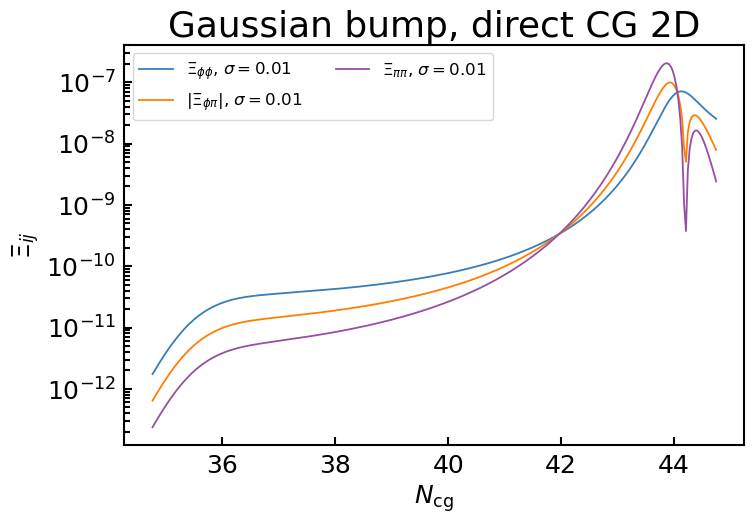

<Figure size 800x520 with 0 Axes>

In [13]:
plt.plot(N_cg_values, covaraince_matrix_array[0, :],
         label=r"$\Xi_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, np.abs(covaraince_matrix_array[1, :]),
         label=r"$|\Xi_{\phi \pi}|$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, covaraince_matrix_array[2, :],
         label=r"$\Xi_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.yscale("log")
plt.ylabel(r"$\Xi_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Gaussian bump, direct CG 2D")
plt.show()
plt.clf()

This is the extended range to allow interpolation. Let's show the range we will actually use.This will require fidning when the modes corresponding to the start and end left the coarse-graining scale (not the Hubble scale).

In [14]:
N_sim_start_sigma_001 = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_sim_end_sigma_001 = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

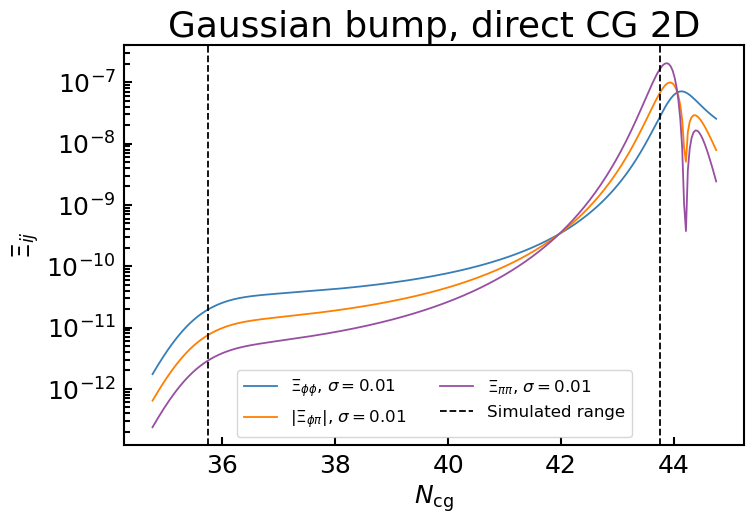

<Figure size 800x520 with 0 Axes>

In [15]:
plt.plot(N_cg_values, covaraince_matrix_array[0, :],
         label=r"$\Xi_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, np.abs(covaraince_matrix_array[1, :]),
         label=r"$|\Xi_{\phi \pi}|$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, covaraince_matrix_array[2, :],
         label=r"$\Xi_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.axvline(x=N_sim_start_sigma_001, color="k", linestyle="dashed", label=r"Simulated range")
plt.axvline(x=N_sim_end_sigma_001, color="k", linestyle="dashed")
plt.yscale("log")
plt.ylabel(r"$\Xi_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Gaussian bump, direct CG 2D")
plt.show()
plt.clf()

We use an extended range to make sure the interpolation we do later is accurate. Let's plot the limited range

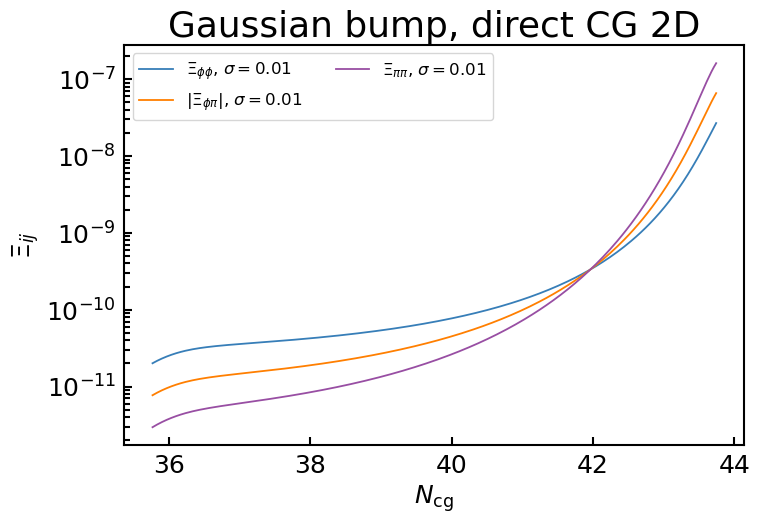

<Figure size 800x520 with 0 Axes>

In [16]:
logic = (N_cg_values>=N_sim_start_sigma_001) & (N_cg_values<=N_sim_end_sigma_001)

plt.plot(N_cg_values[logic], covaraince_matrix_array[0, :][logic],
         label=r"$\Xi_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values[logic], np.abs(covaraince_matrix_array[1, :][logic]),
         label=r"$|\Xi_{\phi \pi}|$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values[logic], covaraince_matrix_array[2, :][logic],
         label=r"$\Xi_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.yscale("log")
plt.ylabel(r"$\Xi_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Gaussian bump, direct CG 2D")
plt.show()
plt.clf()

If one is interesting in using this approach to find the noise, then you need to find the noise matrix, $S = \Xi^2$, from the above. Let's do this using eigen decomposition

In [17]:
# We need a constant to normalise the covariance to reasonable values, 
# to make taking the squareroot more accurate

diff_const = hubble_param_interpolation(N_usr_start)/(2*np.pi)

In [18]:
sigma_values = np.array([1.0, 0.5, 0.1, 0.01])

sigma_index = 3

sigma = sigma_values[sigma_index]

# Create the coarse-grained N values array
logic = (N_modes>N_sim_start-1) & ((N_modes<=N_sim_end+1))
N_modes_interest = N_modes[logic]

N_cg_values = np.zeros(len(N_modes_interest))

# Also need to slice the R modes
R_values_interest = R_at_sigma_values[sigma_index, logic]
R_diff_values_interest = R_diff_at_sigma_values[sigma_index, logic]

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))

N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

k_in_scale = aH_interpolation(N_sim_start)
k_end_scale = aH_interpolation(N_sim_end)

# As it is a symmetric matrix, only need to store 3 values
noise_matrix_array = np.zeros((3, len(N_modes_interest)))

for i in range(len(N_modes_interest)):
    N_mode_exit = N_modes_interest[i]

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    # Find when this mode left the coarse-graining scale
    N_eval = find_cg_time(k, sigma, N_mode_exit)
    N_cg_values[i] = N_eval

    R_at_sigma = R_values_interest[i]
    R_diff_at_sigma = R_diff_values_interest[i]

    # Now we can find delta phi from these values
    delta_phi_at_sigma = delta_phi_from_R(N_eval, R_at_sigma, R_diff_at_sigma)
    delta_phi_deriv_at_sigma = delta_phi_N_derivative_from_R(N_eval, R_at_sigma, R_diff_at_sigma)

    epsilon1 = epsilon1_interpolation(N_eval)
    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    covaraince_matrix = np.array([[covar_matrix[0], covar_matrix[1]], [covar_matrix[2], covar_matrix[3]]])
    covaraince_matrix = covaraince_matrix/(diff_const**2)
    covaraince_matrix = covaraince_matrix.real
    eigenvalues, eigenvectors = np.linalg.eig(covaraince_matrix)
    # Find the inverse eigenvector for diagonalisation
    eigenvectors_inverse = np.linalg.inv(eigenvectors)
    # Now find the square root of the eigen value matrix
    Lambda_root = np.asmatrix([[eigenvalues[0]**0.5, 0], [0, eigenvalues[1]**0.5]])
    noise_matrix = eigenvectors*Lambda_root*eigenvectors_inverse
    noise_matrix_array[0, i] = noise_matrix[0, 0]
    noise_matrix_array[1, i] = noise_matrix[0, 1]
    noise_matrix_array[2, i] = noise_matrix[1, 1]

# Rescale at the end
noise_matrix_array = noise_matrix_array*(diff_const)

/tmp/ipykernel_1150606/2636905509.py:56: RuntimeWarning: invalid value encountered in double_scalars
  Lambda_root = np.asmatrix([[eigenvalues[0]**0.5, 0], [0, eigenvalues[1]**0.5]])


Note that it is difficult to find the square root of an almost singular matrix, hence the NaN dta points.

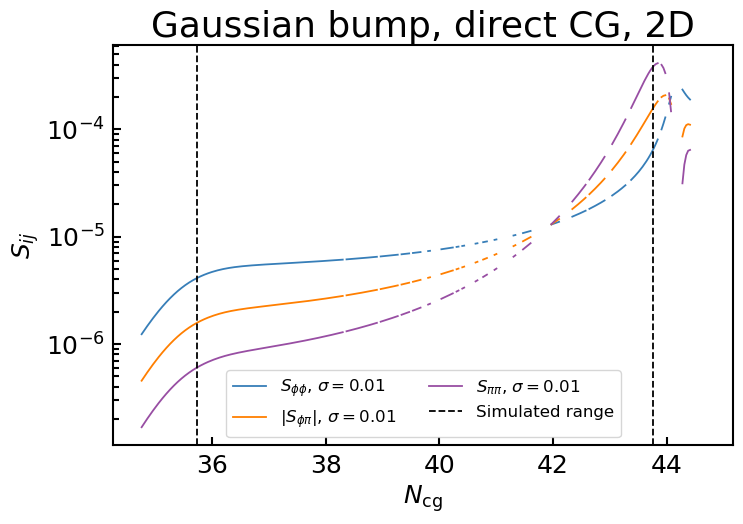

<Figure size 800x520 with 0 Axes>

In [19]:
plt.plot(N_cg_values, noise_matrix_array[0, :],
         label=r"$S_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, np.abs(noise_matrix_array[1, :]),
         label=r"$|S_{\phi \pi}|$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, noise_matrix_array[2, :],
         label=r"$S_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.axvline(x=N_sim_start_sigma_001, color="k", linestyle="dashed", label=r"Simulated range")
plt.axvline(x=N_sim_end_sigma_001, color="k", linestyle="dashed")
plt.yscale("log")
plt.ylabel(r"$S_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Gaussian bump, direct CG, 2D")
plt.show()
plt.clf()

These are clear gaps due to NaN! But the overall curve is clear. Let's remove the NaN data points and replot.

In [20]:
nan_logic = ~np.isnan(noise_matrix_array[0, :])
N_cg_values = N_cg_values[nan_logic]
if any(nan_logic==False):
    print("Number of nan noise data points")
    print(len(N_modes_interest) - len(N_cg_values))

noise_matrix_array = noise_matrix_array[:, nan_logic]

Number of nan noise data points
61


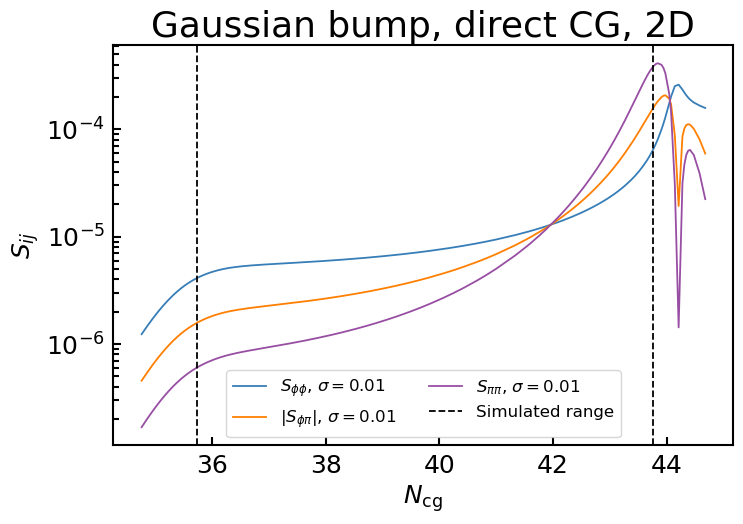

<Figure size 800x520 with 0 Axes>

In [21]:
plt.plot(N_cg_values, noise_matrix_array[0, :],
         label=r"$S_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, np.abs(noise_matrix_array[1, :]),
         label=r"$|S_{\phi \pi}|$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values, noise_matrix_array[2, :],
         label=r"$S_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.axvline(x=N_sim_start_sigma_001, color="k", linestyle="dashed", label=r"Simulated range")
plt.axvline(x=N_sim_end_sigma_001, color="k", linestyle="dashed")
plt.yscale("log")
plt.ylabel(r"$S_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Gaussian bump, direct CG, 2D")
plt.show()
plt.clf()

## Bessel matched approach
### 2D noise
Now let us use the approach to find the noise in the paper. This utilises a Bessel-function anzats, valid when the parameter $\nu^2$ is close to a constant, to find the homogeneous component of $\delta \phi$. The functions required to do this are below.

In [22]:
def comoving_time_func(N_interest, N_end):
    def comoving_time_integrand(N):
        aH = aH_interpolation(N)
        return 1/aH
    comoving_time_value, _ = quad(comoving_time_integrand, N_end, N_interest, limit=1000)
    return comoving_time_value

def besselj_derivative_func(comoving_time, nu, k):
    J_plus_1 = besselj_func(nu+1, -k*comoving_time)
    J_minus_1 = besselj_func(nu-1, -k*comoving_time)
    return (k/2)*(J_plus_1 - J_minus_1)

def bessely_derivative_func(comoving_time, nu, k):
    Y_plus_1 = bessely_func(nu+1, -k*comoving_time)
    Y_minus_1 = bessely_func(nu-1, -k*comoving_time)
    return (k/2)*(Y_plus_1 - Y_minus_1)

def R_matching_to_Bessels(R, R_diff, N_interest, N_end, nu, k):
    comoving_time = comoving_time_func(N_interest, N_end)
    epsilon1 = epsilon1_interpolation(N_interest)
    epsilon2 = epsilon2_interpolation(N_interest)
    a = a_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    z = (2*epsilon1*a**2)**0.5
    z_prime_z = aH*(1 + 0.5*epsilon2)
    extra_term = -(z_prime_z + 1/(-2*comoving_time))
    besselj_value = besselj_func(nu, -k*comoving_time)
    bessely_value = bessely_func(nu, -k*comoving_time)
    besselj_diff_value = besselj_derivative_func(comoving_time, nu, k)
    bessely_diff_value = bessely_derivative_func(comoving_time, nu, k)
    # Need to convert to comoving time
    R_prime = aH*R_diff
    # Factor to change to R
    prefactor = ((-comoving_time)**0.5)/z
    # Now the different pre-factors needed to find A and B
    c = prefactor*besselj_value
    d = prefactor*bessely_value
    e = prefactor*(extra_term*besselj_value + besselj_diff_value)
    f = prefactor*(extra_term*bessely_value + bessely_diff_value)
    # Now just need to solve standard system of simultanious equations
    B = (c*R_prime - e*R)/(c*f - d*e)
    A = (R - B*d)/c
    return complex(A), complex(B)

def homogeneous_Bessel_delta_phi(N_interest, N_end, nu, k, A, B, just_growing=False):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_comoving_time = -k*comoving_time
    a = a_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    term1 = (A/gamma_func(nu+1) - B*gamma_func(-nu)*np.cos(nu*np.pi)/np.pi)*(0.5*k_comoving_time)**nu
    term2 = (-B*gamma_func(nu)/np.pi)*(0.5*k_comoving_time)**-nu
    if just_growing==True:
        sasaki_mukanov = (term2)*(-comoving_time)**0.5
    else:
        sasaki_mukanov = (term1 + term2)*(-comoving_time)**0.5
    delta_phi = sasaki_mukanov/a
    return complex(delta_phi)

def homogeneous_Bessel_delta_phi_N_derivative(N_interest, N_end, nu, k, A, B, just_growing=False):
    comoving_time = comoving_time_func(N_interest, N_end)
    k_comoving_time = -k*comoving_time
    a = a_interpolation(N_interest)
    aH = aH_interpolation(N_interest)
    extra_term = (-aH + 0.5/comoving_time)
    d = (-B*gamma_func(nu)/np.pi)
    if just_growing==True:
        # this is the coefficent of the decaying mde, so if we set it to zero we are neglecting it
        c = 0.
    else:
        c = (A/gamma_func(nu+1) - B*gamma_func(-nu)*np.cos(nu*np.pi)/np.pi)
    # This includes the 1/aH from changing to an N derivative, dN = aH d comoving time
    prefactor = ((-comoving_time)**0.5)/(aH*a)
    term_1 = extra_term*(c*(0.5*k_comoving_time)**(nu) + d*(0.5*k_comoving_time)**(-nu))
    term_2 = 0.5*(nu*k)*(-c*(0.5*k_comoving_time)**(nu-1) + d*(0.5*k_comoving_time)**(-nu - 1))
    delta_phi_homo_derivative = prefactor*(term_1 + term_2)
    return complex(delta_phi_homo_derivative)

Now let's find the noise matrix for $\sigma=0.01$ for the case of homogeneous matching.

In [23]:
# Also need to define the dN used for the numerical steps later. We use a smaller value of the smallest RK45 step
dN = 0.1*np.min(np.diff(N_values))
print("step is")
print(dN)

step is
0.00023659513392999544


In [24]:
sigma_values = np.array([1.0, 0.5, 0.1, 0.01])

sigma_index = 3

sigma = sigma_values[sigma_index]

# Create the coarse-grained N values array
logic = (N_modes>N_sim_start-1) & ((N_modes<=N_sim_end+1))
N_modes_interest = N_modes[logic]

N_cg_values = np.zeros(len(N_modes_interest))

# Also need to slice the R modes
R_values_interest = R_at_sigma_values[sigma_index, logic]
R_diff_values_interest = R_diff_at_sigma_values[sigma_index, logic]

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))

N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

k_in_scale = aH_interpolation(N_sim_start)
k_end_scale = aH_interpolation(N_sim_end)

noise_matrix_array_for_interpolation = np.zeros((3, len(N_modes_interest)))
for i in range(len(N_modes_interest)):
    N_mode_exit = N_modes_interest[i]

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    # Find when this mode left the coarse-graining scale
    N_eval = find_cg_time(k, sigma, N_mode_exit)
    N_cg_values[i] = N_eval

    R_at_sigma = R_values_interest[i]
    R_diff_at_sigma = R_diff_values_interest[i]

    nu_squared = nu_squared_interpolation(N_eval)
    if nu_squared<0:
        nu = complex(nu_squared_interpolation(N_eval), 0)**0.5
    else:
        nu = nu_squared**0.5

    A, B = R_matching_to_Bessels(R_at_sigma, R_diff_at_sigma, N_eval, N_end, nu, k)
    # Now we can find delta phi from these values
    delta_phi_at_sigma =\
        homogeneous_Bessel_delta_phi(N_eval, N_end, nu, k, A, B)
    delta_phi_deriv_at_sigma =\
        homogeneous_Bessel_delta_phi_N_derivative(N_eval, N_end, nu, k, A, B)

    epsilon1 = epsilon1_interpolation(N_eval)
    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    covaraince_matrix = np.array([[covar_matrix[0], covar_matrix[1]], [covar_matrix[2], covar_matrix[3]]])
    # Normalise to hopefully mke the square root more accurate
    covaraince_matrix = covaraince_matrix/(diff_const**2)
    covaraince_matrix = covaraince_matrix.real
    eigenvalues, eigenvectors = np.linalg.eig(covaraince_matrix)
    # Find the inverse eigenvector for diagonalisation
    eigenvectors_inverse = np.linalg.inv(eigenvectors)
    # Now find the square root of the eigen value matrix
    Lambda_root = np.asmatrix([[eigenvalues[0]**0.5, 0], [0, eigenvalues[1]**0.5]])
    noise_matrix = eigenvectors*Lambda_root*eigenvectors_inverse
    # As this is symmetric, let's convert it back into its usual form
    noise_matrix_array_for_interpolation[0, i] = noise_matrix[0, 0]
    noise_matrix_array_for_interpolation[1, i] = noise_matrix[0, 1]
    noise_matrix_array_for_interpolation[2, i] = noise_matrix[1, 1]

nan_logic = ~np.isnan(noise_matrix_array_for_interpolation[0, :])
N_cg_values = N_cg_values[nan_logic]
if any(nan_logic==False):
    print("Number of nan noise data points")
    print(len(N_modes_interest) - len(N_cg_values))

# Remove the NaN points
noise_matrix_array_for_interpolation = noise_matrix_array_for_interpolation[:, nan_logic]

# Need to rescale back to the correct magnitude
noise_matrix_array_for_interpolation = diff_const*noise_matrix_array_for_interpolation

# Do an interpolation such that the noise at any time of interest can be found
noise_matrix_phi_phi_interpolation = CubicSpline(N_cg_values,
                                                 noise_matrix_array_for_interpolation[0, :])
noise_matrix_phi_pi_interpolation = CubicSpline(N_cg_values,
                                                 noise_matrix_array_for_interpolation[1, :])
noise_matrix_pi_pi_interpolation = CubicSpline(N_cg_values,
                                                 noise_matrix_array_for_interpolation[2, :])

#N_cg_values_for_sim = np.arange(N_start_sigma_exit, N_end_sigma_exit, dN)
N_cg_values_for_sim = np.arange(N_start_sigma_exit, N_end_sigma_exit, dN)
print("Diff in start value")
print(N_cg_values_for_sim[0] - N_start_sigma_exit)
print("Diff in final value")
print(N_cg_values_for_sim[-1] - N_end_sigma_exit)
noise_matrix_array = np.zeros((3, len(N_cg_values_for_sim)))

# Let's find the noise at each time step used
noise_matrix_array[0, :len(N_cg_values_for_sim)] =\
    noise_matrix_phi_phi_interpolation(N_cg_values_for_sim)
noise_matrix_array[1, :len(N_cg_values_for_sim)] =\
    noise_matrix_phi_pi_interpolation(N_cg_values_for_sim)
noise_matrix_array[2, :len(N_cg_values_for_sim)] =\
    noise_matrix_pi_pi_interpolation(N_cg_values_for_sim)

/tmp/ipykernel_1150606/3940784777.py:64: RuntimeWarning: invalid value encountered in double_scalars
  Lambda_root = np.asmatrix([[eigenvalues[0]**0.5, 0], [0, eigenvalues[1]**0.5]])


Number of nan noise data points
41
Diff in start value
0.0
Diff in final value
-1.8588466410562887e-05


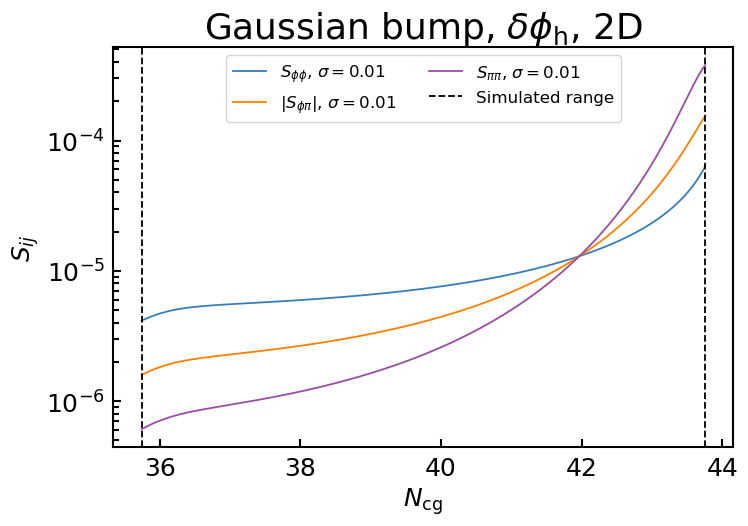

<Figure size 800x520 with 0 Axes>

In [25]:
plt.plot(N_cg_values_for_sim, noise_matrix_array[0, :],
         label=r"$S_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values_for_sim, np.abs(noise_matrix_array[1, :]),
         label=r"$|S_{\phi \pi}|$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values_for_sim, noise_matrix_array[2, :],
         label=r"$S_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.axvline(x=N_sim_start_sigma_001, color="k", linestyle="dashed", label=r"Simulated range")
plt.axvline(x=N_sim_end_sigma_001, color="k", linestyle="dashed")
plt.yscale("log")
plt.ylabel(r"$S_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Gaussian bump, $\delta \phi_{\rm h}$, 2D")
plt.show()
plt.clf()

This looks very similair to the direct coarse grainiing plot, which is to be expected for $\sigma=0.01$ as the $k^2$ correction is minimal.

Now let's save these noise curves for later use.

In [26]:
data_dict = {}
data_dict["N"] = N_cg_values_for_sim
data_dict["phi-phi noise"] = noise_matrix_array[0, :]
data_dict["phi-pi noise"] = noise_matrix_array[1, :]
data_dict["pi-pi noise"] = noise_matrix_array[2, :]

data_pandas = pd.DataFrame(data_dict)

data_pandas.to_csv("gaussian_bump_noise_curves_Bessel_matched_sigma_"+str(sigma)+"_2D.csv")

### 1D noise
We can also find a 1D noise if the decaying mode is dropped. Let's find this for $\sigma=0.01$ initially.

The covariance matrix for 1D noise does not have a squareroot. So instead we just find the noise from the first element and the angle made by the noise in phase space

In [27]:
sigma_values = np.array([1.0, 0.5, 0.1, 0.01])

sigma_index = 3

sigma = sigma_values[sigma_index]

# Create the coarse-grained N values array
logic = (N_modes>N_sim_start-1) & ((N_modes<=N_sim_end+1))
N_modes_interest = N_modes[logic]

N_cg_values = np.zeros(len(N_modes_interest))

# Also need to slice the R modes
R_values_interest = R_at_sigma_values[sigma_index, logic]
R_diff_values_interest = R_diff_at_sigma_values[sigma_index, logic]

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))

N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

k_in_scale = aH_interpolation(N_sim_start)
k_end_scale = aH_interpolation(N_sim_end)

noise_matrix_array_for_interpolation = np.zeros((3, len(N_modes_interest)))
for i in range(len(N_modes_interest)):
    N_mode_exit = N_modes_interest[i]

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    # Find when this mode left the coarse-graining scale
    N_eval = find_cg_time(k, sigma, N_mode_exit)
    N_cg_values[i] = N_eval
    nu = complex(nu_squared_interpolation(N_eval), 0)**0.5

    # We use these values to find the homogeneous behaviour
    R_at_sigma = R_values_interest[i]
    R_diff_at_sigma = R_diff_values_interest[i]
    A, B = R_matching_to_Bessels(R_at_sigma, R_diff_at_sigma, N_eval, N_end, nu, k)
    # Now we can find delta phi from these values
    delta_phi_at_sigma =\
        homogeneous_Bessel_delta_phi(N_eval, N_end, nu, k, A, B, just_growing=True)
    delta_phi_deriv_at_sigma =\
        homogeneous_Bessel_delta_phi_N_derivative(N_eval, N_end, nu, k, A, B, just_growing=True)
    tan_theta = np.real(delta_phi_deriv_at_sigma/delta_phi_at_sigma)

    epsilon1 = epsilon1_interpolation(N_eval)
    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    covar_matrix = covar_matrix.real
    # The phi noise is just the element square root, then pi noise is just this times the ratio
    noise_matrix_array_for_interpolation[0, i] = covar_matrix[0]**0.5
    noise_matrix_array_for_interpolation[1, i] = tan_theta*covar_matrix[0]**0.5

# Do an interpolation such that the noise at any time of interest can be found
noise_matrix_phi_phi_interpolation = CubicSpline(N_cg_values,
                                                 noise_matrix_array_for_interpolation[0, :])
noise_matrix_pi_pi_interpolation = CubicSpline(N_cg_values,
                                                 noise_matrix_array_for_interpolation[1, :])

N_cg_values_for_sim = np.arange(N_start_sigma_exit, N_end_sigma_exit, dN)
noise_matrix_array = np.zeros((2, len(N_cg_values_for_sim)))
# Let's find the noise at each time step used
noise_matrix_array[0, :len(N_cg_values_for_sim)] = noise_matrix_phi_phi_interpolation(N_cg_values_for_sim)
noise_matrix_array[1, :len(N_cg_values_for_sim)] = noise_matrix_pi_pi_interpolation(N_cg_values_for_sim)

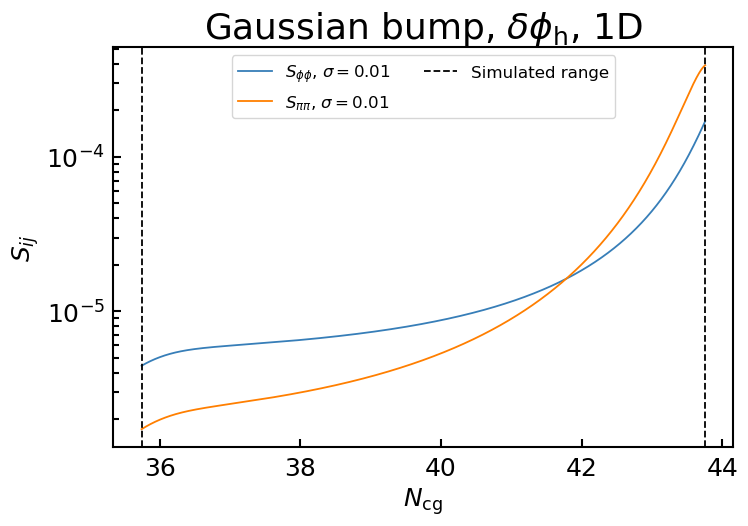

<Figure size 800x520 with 0 Axes>

In [28]:
plt.plot(N_cg_values_for_sim, noise_matrix_array[0, :],
         label=r"$S_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values_for_sim, noise_matrix_array[1, :],
         label=r"$S_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.axvline(x=N_sim_start_sigma_001, color="k", linestyle="dashed", label=r"Simulated range")
plt.axvline(x=N_sim_end_sigma_001, color="k", linestyle="dashed")
plt.yscale("log")
plt.ylabel(r"$S_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Gaussian bump, $\delta \phi_{\rm h}$, 1D")
plt.show()
plt.clf()

One can see this looks very similair to the previous noise plots, as expected.

We can also find the noise near Hubble exit.

In [29]:
sigma_values = np.array([1.0, 0.5, 0.1, 0.01])

sigma_index = 0

sigma = sigma_values[sigma_index]

# Create the coarse-grained N values array
logic = (N_modes>N_sim_start-1) & ((N_modes<=N_sim_end+1))
N_modes_interest = N_modes[logic]

N_cg_values = np.zeros(len(N_modes_interest))

# Also need to slice the R modes
R_values_interest = R_at_sigma_values[sigma_index, logic]
R_diff_values_interest = R_diff_at_sigma_values[sigma_index, logic]

aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))

N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

k_in_scale = aH_interpolation(N_sim_start)
k_end_scale = aH_interpolation(N_sim_end)

noise_matrix_array_for_interpolation = np.zeros((3, len(N_modes_interest)))
for i in range(len(N_modes_interest)):
    N_mode_exit = N_modes_interest[i]

    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

    k = aH_interpolation(N_mode_exit)

    # Find when this mode left the coarse-graining scale
    N_eval = find_cg_time(k, sigma, N_mode_exit)
    N_cg_values[i] = N_eval
    nu = complex(nu_squared_interpolation(N_eval), 0)**0.5

    # We use these values to find the homogeneous behaviour
    R_at_sigma = R_values_interest[i]
    R_diff_at_sigma = R_diff_values_interest[i]
    A, B = R_matching_to_Bessels(R_at_sigma, R_diff_at_sigma, N_eval, N_end, nu, k)
    # Now we can find delta phi from these values
    delta_phi_at_sigma =\
        homogeneous_Bessel_delta_phi(N_eval, N_end, nu, k, A, B, just_growing=True)
    delta_phi_deriv_at_sigma =\
        homogeneous_Bessel_delta_phi_N_derivative(N_eval, N_end, nu, k, A, B, just_growing=True)
    tan_theta = np.real(delta_phi_deriv_at_sigma/delta_phi_at_sigma)

    epsilon1 = epsilon1_interpolation(N_eval)
    covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
    covar_matrix = covar_matrix.real
    # The phi noise is just the element square root, then pi noise is just this times the ratio
    noise_matrix_array_for_interpolation[0, i] = covar_matrix[0]**0.5
    noise_matrix_array_for_interpolation[1, i] = tan_theta*covar_matrix[0]**0.5

# Do an interpolation such that the noise at any time of interest can be found
noise_matrix_phi_phi_interpolation = CubicSpline(N_cg_values,
                                                 noise_matrix_array_for_interpolation[0, :])
noise_matrix_pi_pi_interpolation = CubicSpline(N_cg_values,
                                                 noise_matrix_array_for_interpolation[1, :])

N_cg_values_for_sim = np.arange(N_start_sigma_exit, N_end_sigma_exit, dN)
noise_matrix_array = np.zeros((2, len(N_cg_values_for_sim)))
# Let's find the noise at each time step used
noise_matrix_array[0, :len(N_cg_values_for_sim)] = noise_matrix_phi_phi_interpolation(N_cg_values_for_sim)
noise_matrix_array[1, :len(N_cg_values_for_sim)] = noise_matrix_pi_pi_interpolation(N_cg_values_for_sim)

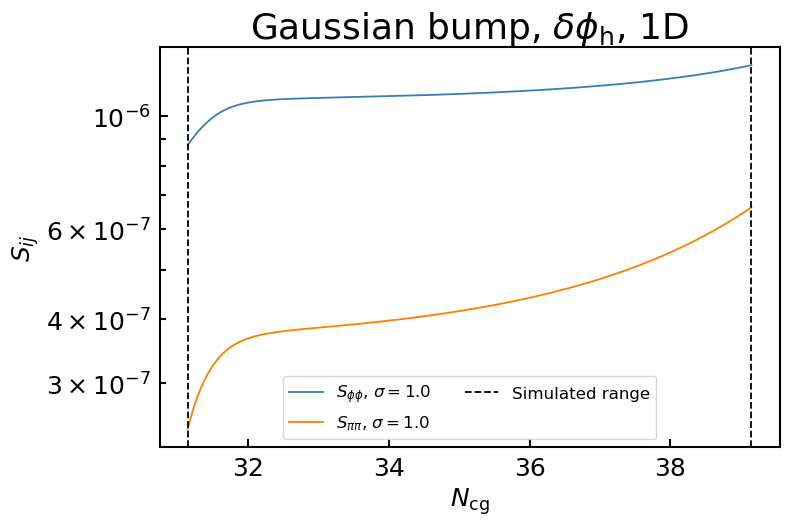

<Figure size 800x520 with 0 Axes>

In [30]:
plt.plot(N_cg_values_for_sim, noise_matrix_array[0, :],
         label=r"$S_{\phi \phi}$, $\sigma=$"+str(sigma))
plt.plot(N_cg_values_for_sim, noise_matrix_array[1, :],
         label=r"$S_{\pi \pi}$, $\sigma=$"+str(sigma))
plt.axvline(x=N_sim_start, color="k", linestyle="dashed", label=r"Simulated range")
plt.axvline(x=N_sim_end, color="k", linestyle="dashed")
plt.yscale("log")
plt.ylabel(r"$S_{ij}$")
plt.xlabel(r"$N_{\rm cg}$")
plt.legend(ncol=2, fontsize=12)
plt.title(r"Gaussian bump, $\delta \phi_{\rm h}$, 1D")
plt.show()
plt.clf()

We can do the same for all of the different $\sigma$ values, and save the different noise curves as we go.

Note that we need to make sure to change the $\mathcal{R}$ and $\partial_N \mathcal{R}$ values we use with $\sigma$

In [31]:
sigma_values = np.array([1.0, 0.5, 0.1, 0.01])

# Create the coarse-grained N values array
logic = (N_modes>N_sim_start-1) & ((N_modes<=N_sim_end+1))
N_modes_interest = N_modes[logic]

for sigma_index in range(len(sigma_values)):
    sigma = sigma_values[sigma_index]
    # Also need to slice the R modes
    R_values_interest = R_at_sigma_values[sigma_index, logic]
    R_diff_values_interest = R_diff_at_sigma_values[sigma_index, logic]

    # Renormalise
    aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_sim_start))
    a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_sim_start))

    N_start_sigma_exit = find_cg_time(aH_interpolation(N_sim_start), sigma, N_sim_start)
    N_end_sigma_exit = find_cg_time(aH_interpolation(N_sim_end), sigma, N_sim_end)

    N_cg_values = np.zeros(len(N_modes_interest))

    noise_matrix_array_for_interpolation = np.zeros((3, len(N_modes_interest)))
    for i in range(len(N_modes_interest)):
        N_mode_exit = N_modes_interest[i]

        aH_interpolation = CubicSpline(N_values, hubble_param_values*a_in*np.exp(N_values-N_mode_exit))
        a_interpolation = CubicSpline(N_values, a_in*np.exp(N_values-N_mode_exit))

        k = aH_interpolation(N_mode_exit)

        # Find when this mode left the coarse-graining scale
        N_eval = find_cg_time(k, sigma, N_mode_exit)
        N_cg_values[i] = N_eval
        nu = complex(nu_squared_interpolation(N_eval), 0)**0.5

        # We use these values to find the homogeneous behaviour
        R_at_sigma = R_values_interest[i]
        R_diff_at_sigma = R_diff_values_interest[i]
        A, B = R_matching_to_Bessels(R_at_sigma, R_diff_at_sigma, N_eval, N_end, nu, k)
        # Now we can find delta phi from these values
        delta_phi_at_sigma =\
            homogeneous_Bessel_delta_phi(N_eval, N_end, nu, k, A, B, just_growing=True)
        delta_phi_deriv_at_sigma =\
            homogeneous_Bessel_delta_phi_N_derivative(N_eval, N_end, nu, k, A, B, just_growing=True)
        tan_theta = np.real(delta_phi_deriv_at_sigma/delta_phi_at_sigma)

        epsilon1 = epsilon1_interpolation(N_eval)
        covar_matrix = correlation_matrix(delta_phi_at_sigma, delta_phi_deriv_at_sigma, k, epsilon1)
        covar_matrix = covar_matrix.real
        # The phi noise is just the element square root, then pi noise is just this times the ratio
        noise_matrix_array_for_interpolation[0, i] = covar_matrix[0]**0.5
        noise_matrix_array_for_interpolation[1, i] = tan_theta*covar_matrix[0]**0.5

    # Do an interpolation such that the noise at any time of interest can be found
    noise_matrix_phi_phi_interpolation = CubicSpline(N_cg_values,
                                                     noise_matrix_array_for_interpolation[0, :])
    noise_matrix_pi_pi_interpolation = CubicSpline(N_cg_values,
                                                     noise_matrix_array_for_interpolation[1, :])

    N_cg_values_for_sim = np.arange(N_start_sigma_exit, N_end_sigma_exit, dN)
    noise_matrix_array = np.zeros((2, len(N_cg_values_for_sim)))
    # Let's find the noise at each time step used
    noise_matrix_array[0, :len(N_cg_values_for_sim)] = noise_matrix_phi_phi_interpolation(N_cg_values_for_sim)
    noise_matrix_array[1, :len(N_cg_values_for_sim)] = noise_matrix_pi_pi_interpolation(N_cg_values_for_sim)
    
    # Save these curves
    data_dict = {}
    data_dict["N"] = N_cg_values_for_sim
    data_dict["phi-phi noise"] = noise_matrix_array[0, :]
    data_dict["pi-pi noise"] = noise_matrix_array[1, :]

    data_pandas = pd.DataFrame(data_dict)

    data_pandas.to_csv("gaussian_bump_noise_curves_Bessel_matched_sigma_"+str(sigma)+"_1D.csv")